This is an exploration of the whole series of mortality data from the CDC.

First let's configure logging, including turning off the preconfigured loggers.

In [1]:
from logging import Formatter
from logging import getLogger
from logging import INFO
from logging import StreamHandler

logger = getLogger(__name__)
logger.handlers.clear()
handler = StreamHandler()
handler.setLevel(INFO)
handler.setFormatter(Formatter('%(name)s - %(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(handler)

Let's list all the files. We note that we have data files in CSV format representing the years 2005-2015, inclusive (11 years).

In [2]:
from os import walk
from os.path import join

for dirname, _, filenames in walk('../input/mortality/'):
    for filename in filenames:
        logger.info(msg=join(dirname, filename))

__main__ - 2023-06-16 17:09:52,408 - INFO - ../input/mortality/2014_codes.json
__main__ - 2023-06-16 17:09:52,410 - INFO - ../input/mortality/2007_data.csv
__main__ - 2023-06-16 17:09:52,411 - INFO - ../input/mortality/2007_codes.json
__main__ - 2023-06-16 17:09:52,412 - INFO - ../input/mortality/2012_data.csv
__main__ - 2023-06-16 17:09:52,414 - INFO - ../input/mortality/2010_data.csv
__main__ - 2023-06-16 17:09:52,415 - INFO - ../input/mortality/2009_data.csv
__main__ - 2023-06-16 17:09:52,416 - INFO - ../input/mortality/2011_data.csv
__main__ - 2023-06-16 17:09:52,417 - INFO - ../input/mortality/2015_codes.json
__main__ - 2023-06-16 17:09:52,418 - INFO - ../input/mortality/2011_codes.json
__main__ - 2023-06-16 17:09:52,420 - INFO - ../input/mortality/2006_data.csv
__main__ - 2023-06-16 17:09:52,421 - INFO - ../input/mortality/2010_codes.json
__main__ - 2023-06-16 17:09:52,423 - INFO - ../input/mortality/2005_data.csv
__main__ - 2023-06-16 17:09:52,424 - INFO - ../input/mortality/200

In [3]:
from json import load
with open(file='../input/mortality/2013_codes.json', mode='r', encoding='utf-8', ) as codes_fp:
    codes = load(fp=codes_fp,)
for key in codes.keys():
    logger.info(msg=key)

__main__ - 2023-06-16 17:09:52,475 - INFO - resident_status
__main__ - 2023-06-16 17:09:52,476 - INFO - education_1989_revision
__main__ - 2023-06-16 17:09:52,477 - INFO - education_2003_revision
__main__ - 2023-06-16 17:09:52,478 - INFO - education_reporting_flag
__main__ - 2023-06-16 17:09:52,479 - INFO - month_of_death
__main__ - 2023-06-16 17:09:52,482 - INFO - sex
__main__ - 2023-06-16 17:09:52,483 - INFO - age_substitution_flag
__main__ - 2023-06-16 17:09:52,484 - INFO - age_recode_52
__main__ - 2023-06-16 17:09:52,485 - INFO - age_recode_27
__main__ - 2023-06-16 17:09:52,485 - INFO - age_recode_12
__main__ - 2023-06-16 17:09:52,486 - INFO - infant_age_recode_22
__main__ - 2023-06-16 17:09:52,489 - INFO - place_of_death_and_decedents_status
__main__ - 2023-06-16 17:09:52,490 - INFO - marital_status
__main__ - 2023-06-16 17:09:52,491 - INFO - day_of_week_of_death
__main__ - 2023-06-16 17:09:52,492 - INFO - current_data_year
__main__ - 2023-06-16 17:09:52,492 - INFO - injury_at_wor

If we try to load up all of the data we may run out of memory, so let's start by doing one big load of just the columns we initially want across all 11 years; we'll use a list comprehension and concat() to avoid saving two copies of the data, and we'll hide the progress information in our CSV reading code. We have one year where one column is named differently, so we have to modify the used columns based on the year.

In [4]:
from pandas import concat
from pandas import read_csv
from pandas import DataFrame

USECOLS = ['activity_code', 'autopsy', 'current_data_year', 'day_of_week_of_death', 'detail_age', 'education_reporting_flag',
           'injury_at_work', 'manner_of_death', 'marital_status', 'method_of_disposition', 'month_of_death', 
           'place_of_death_and_decedents_status', 'race', 'resident_status', 'sex']

def get_usecols(year: int) -> list:
    return sorted(USECOLS + ['icd_code_10th_revision']) if year != 2012 else sorted(USECOLS + ['icd_code_10'])

def read(filename: str, usecols: list, ) -> DataFrame:
    logger = getLogger(name=__name__)
    logger.info(msg='reading {}'.format(filename))
    result_df = read_csv(filepath_or_buffer=filename, low_memory=False, usecols=usecols, )
    if 'icd_code_10' in result_df.columns:
        result_df = result_df.rename(columns={'icd_code_10': 'icd_code_10th_revision'})
    logger.info(msg='read {} rows.'.format(len(result_df)))
    logger.debug(msg=result_df.columns)
    return result_df

df = concat([read(filename='../input/mortality/{}_data.csv'.format(year),
                  usecols=get_usecols(year), ) for year in range(2005, 2016)])

# we are only interested in the codes for which we have DataFrame columns
codes = {key: value for key, value in codes.items() if key in df.columns}

__main__ - 2023-06-16 17:09:52,593 - INFO - reading ../input/mortality/2005_data.csv
__main__ - 2023-06-16 17:10:14,548 - INFO - read 2452506 rows.
__main__ - 2023-06-16 17:10:14,549 - INFO - reading ../input/mortality/2006_data.csv
__main__ - 2023-06-16 17:10:33,093 - INFO - read 2430725 rows.
__main__ - 2023-06-16 17:10:33,095 - INFO - reading ../input/mortality/2007_data.csv
__main__ - 2023-06-16 17:10:51,548 - INFO - read 2428343 rows.
__main__ - 2023-06-16 17:10:51,549 - INFO - reading ../input/mortality/2008_data.csv
__main__ - 2023-06-16 17:11:10,155 - INFO - read 2476811 rows.
__main__ - 2023-06-16 17:11:10,156 - INFO - reading ../input/mortality/2009_data.csv
__main__ - 2023-06-16 17:11:28,640 - INFO - read 2441219 rows.
__main__ - 2023-06-16 17:11:28,641 - INFO - reading ../input/mortality/2010_data.csv
__main__ - 2023-06-16 17:11:47,243 - INFO - read 2472542 rows.
__main__ - 2023-06-16 17:11:47,244 - INFO - reading ../input/mortality/2011_data.csv
__main__ - 2023-06-16 17:12

Let's see how much data we have.

In [5]:
logger.info(msg='row count: {:,}'.format(len(df)))
logger.info(msg='bytes: {:,}'.format(df.memory_usage().sum()))

__main__ - 2023-06-16 17:13:56,739 - INFO - row count: 27,720,673
__main__ - 2023-06-16 17:13:56,744 - INFO - bytes: 3,770,011,528


Let's make our first graph: a plot of the total deaths for each year.
And let's use lmplot() to include a trend line.

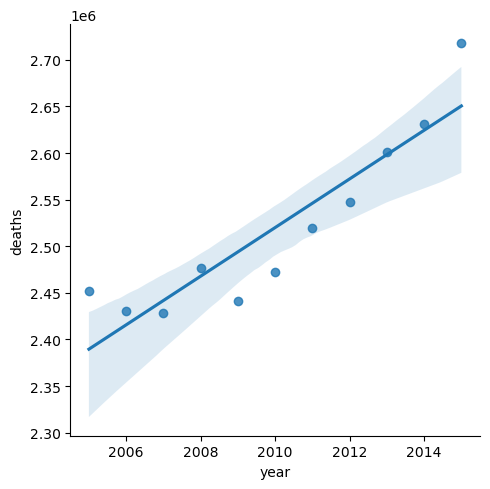

In [6]:
from seaborn import lmplot
%matplotlib inline
annual_total_df = df['current_data_year'].value_counts().to_frame(name='deaths').reset_index()
annual_total_df.columns = ['year', 'deaths']
lmplot(data=annual_total_df, x='year', y='deaths',)

Let's try splitting out male and female deaths.

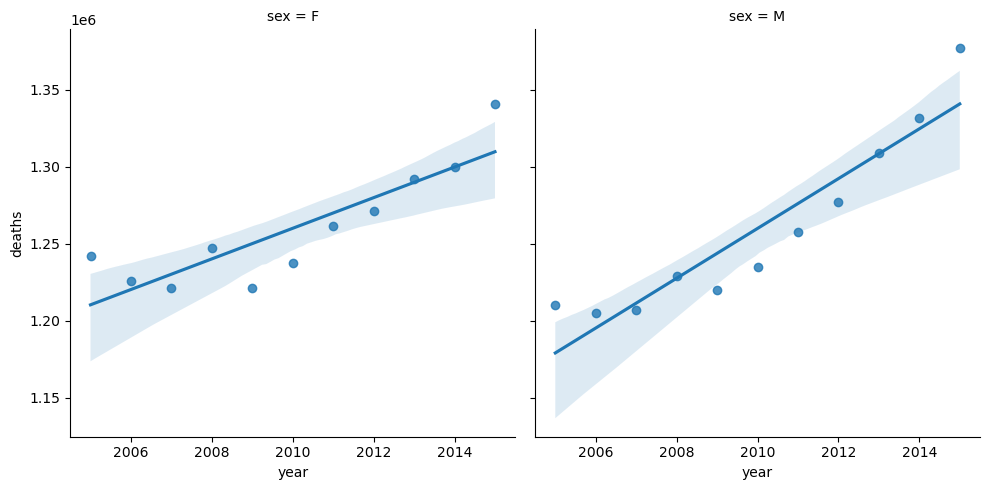

In [7]:
annual_total_df = annual_total_df.rename(columns={'deaths': 'total'})
plot_df = df.groupby(by=['current_data_year', 'sex']).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'})
lmplot(col='sex', data=plot_df, x='year', y='deaths',)
column = 'sex'
for item in plot_df[column].unique():
    title = '{} = {}'.format(column, item)
    if title in annual_total_df.columns:
        annual_total_df = annual_total_df.drop(columns=[title],)
    annual_total_df = annual_total_df.merge(right=plot_df[plot_df[column] == item], on='year').drop(columns=[column]).rename(columns={'deaths' : title})

Let's get the race names, add a column for the race name, and split out the deaths by race. Here we are shortening some group names and combining some groups.

In [8]:
to_replace = {int(key): value for key, value in codes['race'].items()}
to_replace[3] = 'Native American'
to_replace[6] = 'Hawaiian'
to_replace[8] = 'Other Asian'
to_replace[68] = 'Other Asian'
to_replace[78] = 'Other Asian'
df['race_name'] = df['race'].replace(to_replace=to_replace)
logger.info(msg=df['race_name'].value_counts().to_dict())

__main__ - 2023-06-16 17:14:19,944 - INFO - {'White': 23703335, 'Black': 3258257, 'Native American': 174392, 'Chinese': 125944, 'Other Asian': 119799, 'Filipino': 106432, 'Japanese': 78973, 'Asian Indian': 55418, 'Korean': 42810, 'Vietnamese': 39420, 'Hawaiian': 7363, 'Samoan': 5688, 'Guamanian': 2842}


__main__ - 2023-06-16 17:14:31,078 - INFO - 
    year    total  sex = F  sex = M  Asian Indian   Black  Chinese  Filipino  \
0   2015  2718198  1341033  1377165          8131  320759    14526     12041   
1   2014  2631171  1299710  1331461          6778  309504    13297     11074   
2   2013  2601452  1292382  1309070          6260  303461    12934     11063   
3   2012  2547864  1271045  1276819          5574  295769    12414     10223   
4   2011  2519842  1261876  1257966          5020  290593    11715      9790   
5   2008  2476811  1247414  1229397          3992  289629    10301      8699   
6   2010  2472542  1237340  1235202          4723  287434    10974      9511   
7   2005  2452506  1241896  1210610          3326  293389     9633      8128   
8   2009  2441219  1221099  1220120          4352  287137    10447      8912   
9   2006  2430725  1225794  1204931          3550  290461     9798      8482   
10  2007  2428343  1221287  1207056          3712  290121     9905      850

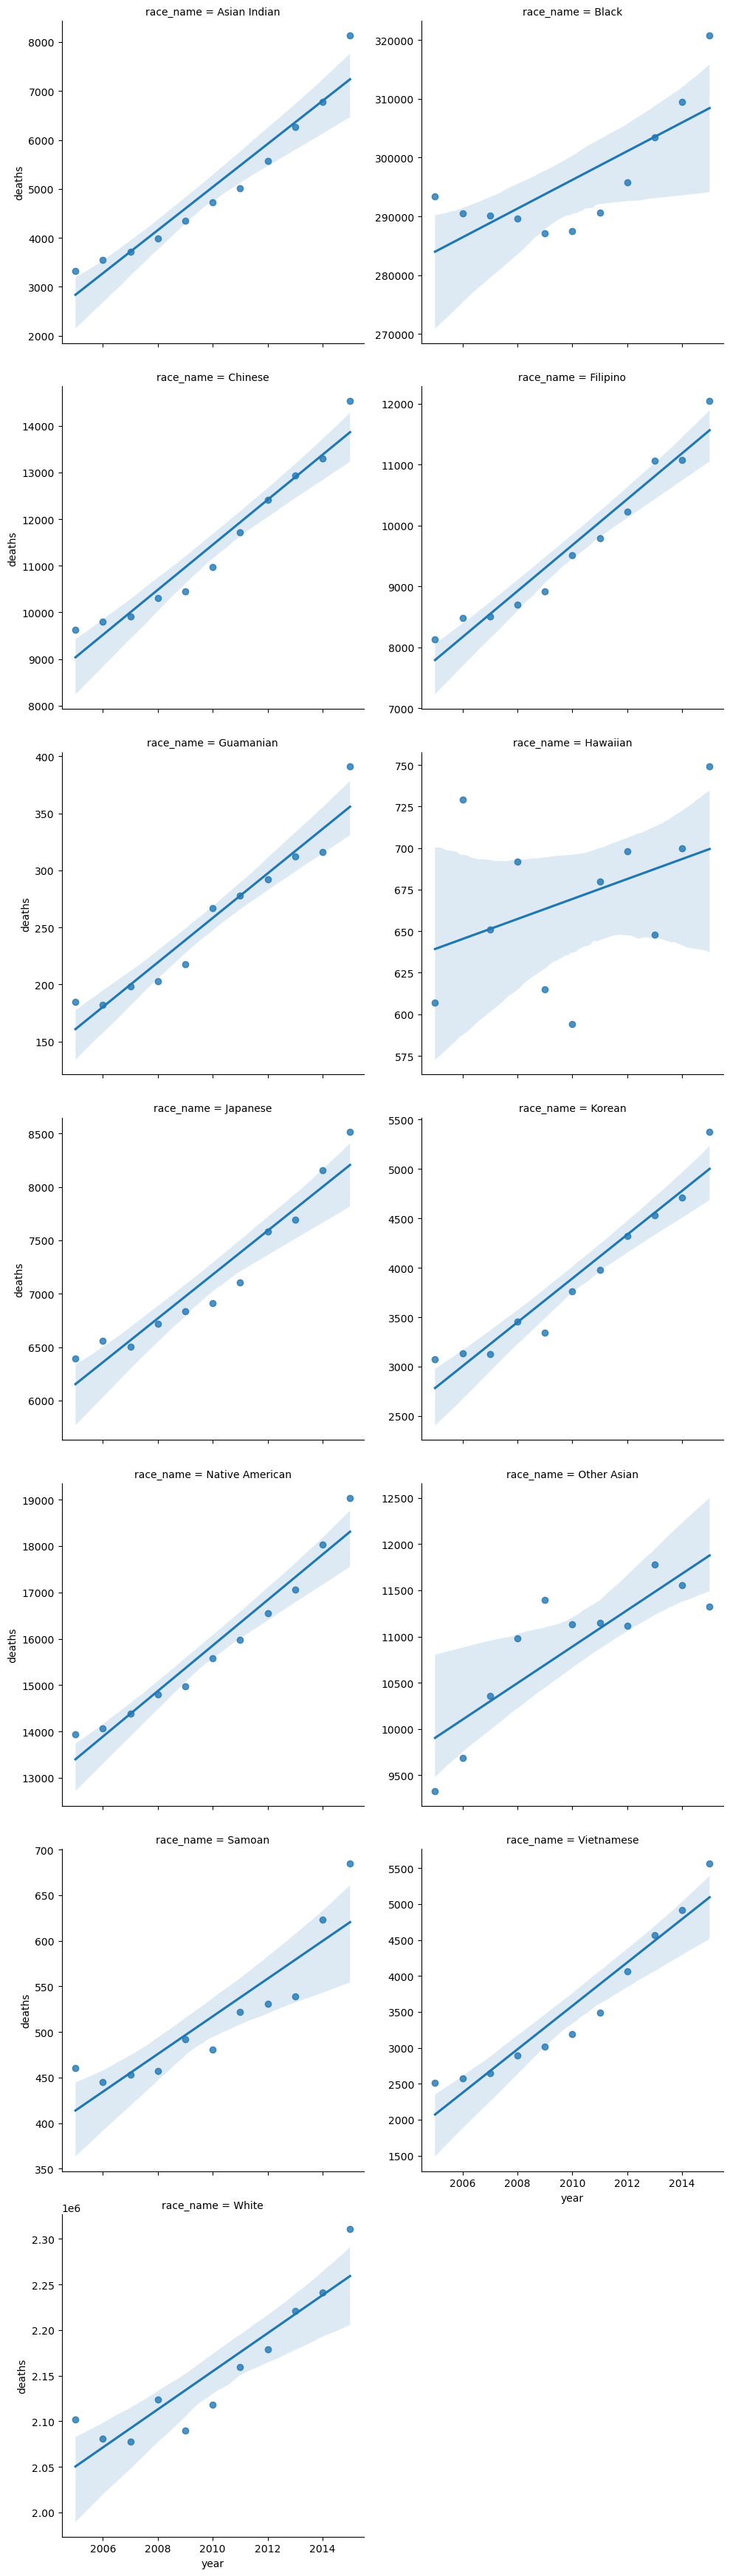

In [9]:
plot_df = df.groupby(by=['current_data_year', 'race_name']).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'})
lmplot(col='race_name', col_wrap=2, data=plot_df, facet_kws=dict(sharey=False), seed=1, x='year', y='deaths',)
column = 'race_name'
for item in plot_df[column].unique():
    title = '{}'.format(item)
    if title in annual_total_df.columns:
        annual_total_df = annual_total_df.drop(columns=[title],)
    annual_total_df = annual_total_df.merge(right=plot_df[plot_df[column] == item], on='year').drop(columns=[column]).rename(columns={'deaths' : title})
logger.info(msg='\n{}'.format(annual_total_df))

<Axes: >

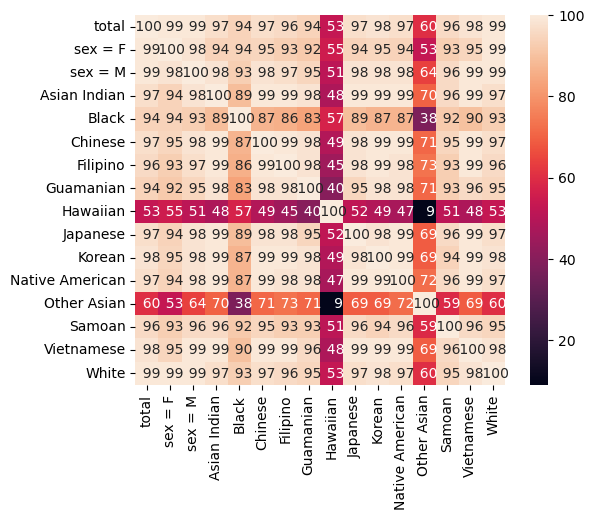

In [10]:
from seaborn import heatmap
corr_df = data=(100 * annual_total_df.drop(columns=['year'],).corr()).astype(int)
heatmap(annot=True, data=corr_df, fmt='4d', square=True, )

<Axes: >

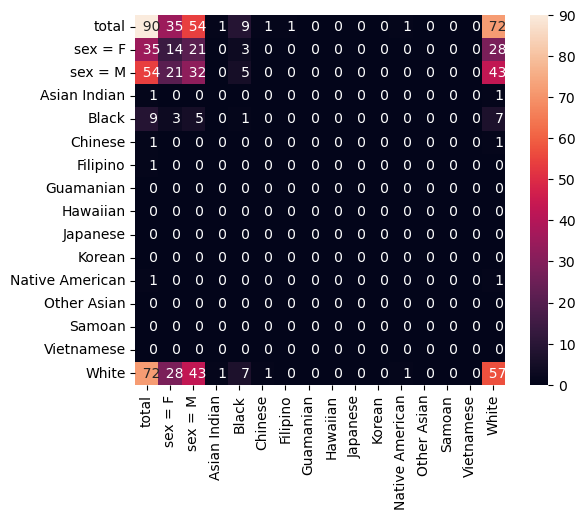

In [11]:
cov_df = data=(1e-8 * annual_total_df.drop(columns=['year'],).cov()).astype(int)
heatmap(annot=True, data=cov_df, fmt='4d', square=True, )

Now let's start digging into cause of death data, which is encoded as an ICD code.

In [12]:
column = 'icd_code_10th_revision'
icd_counts = list(df[column].value_counts().to_dict().items())
top_n = 10
logger.info(icd_counts[:top_n])
icd_codes = [item[0] for item in icd_counts[:top_n]]
icd_df = df[df[column].isin(icd_codes)]
logger.info(msg=icd_codes)
logger.info(msg=icd_df.shape)

__main__ - 2023-06-16 17:14:45,187 - INFO - [('I251', 1936376), ('C349', 1723585), ('I219', 1388327), ('J449', 1136896), ('F03', 1049358), ('G309', 896200), ('I64', 755369), ('I250', 657654), ('I500', 607764), ('J189', 512409)]
__main__ - 2023-06-16 17:15:05,945 - INFO - ['I251', 'C349', 'I219', 'J449', 'F03', 'G309', 'I64', 'I250', 'I500', 'J189']
__main__ - 2023-06-16 17:15:05,947 - INFO - (10663938, 17)


__main__ - 2023-06-16 17:15:13,444 - INFO - 
      I251    C349    I219    J449     F03    G309    I64   I250   I500   J189
0   164042  152673  112297  114179  107881  108409  64698  60971  64923  45588
1   161961  154862  114107  107836  122021   91356  65578  60471  60420  44685
2   165255  155497  116872  107663  129255   82363  65785  59780  57840  47118
3   166452  156782  117996  103545  122427   81010  66492  59478  53790  44073
4   168025  156262  119964  101072  111852   82340  67214  59237  52544  46214
5   183626  157965  134053   94736   83332   80320  70731  58937  51719  48466
6   171627  157595  122093   98022   98190   80744  68416  57720  52288  43864
7   201017  158481  150972  107324   51934   69449  74482  63082  54906  53058
8   175507  157421  125495   93246   84991   77062  68230  57291  51383  44653
9   193479  157929  141472  103197   65186   70500  72545  61351  55955  48041
10  185385  158118  133006  106076   72289   72647  71198  59336  51996  46649


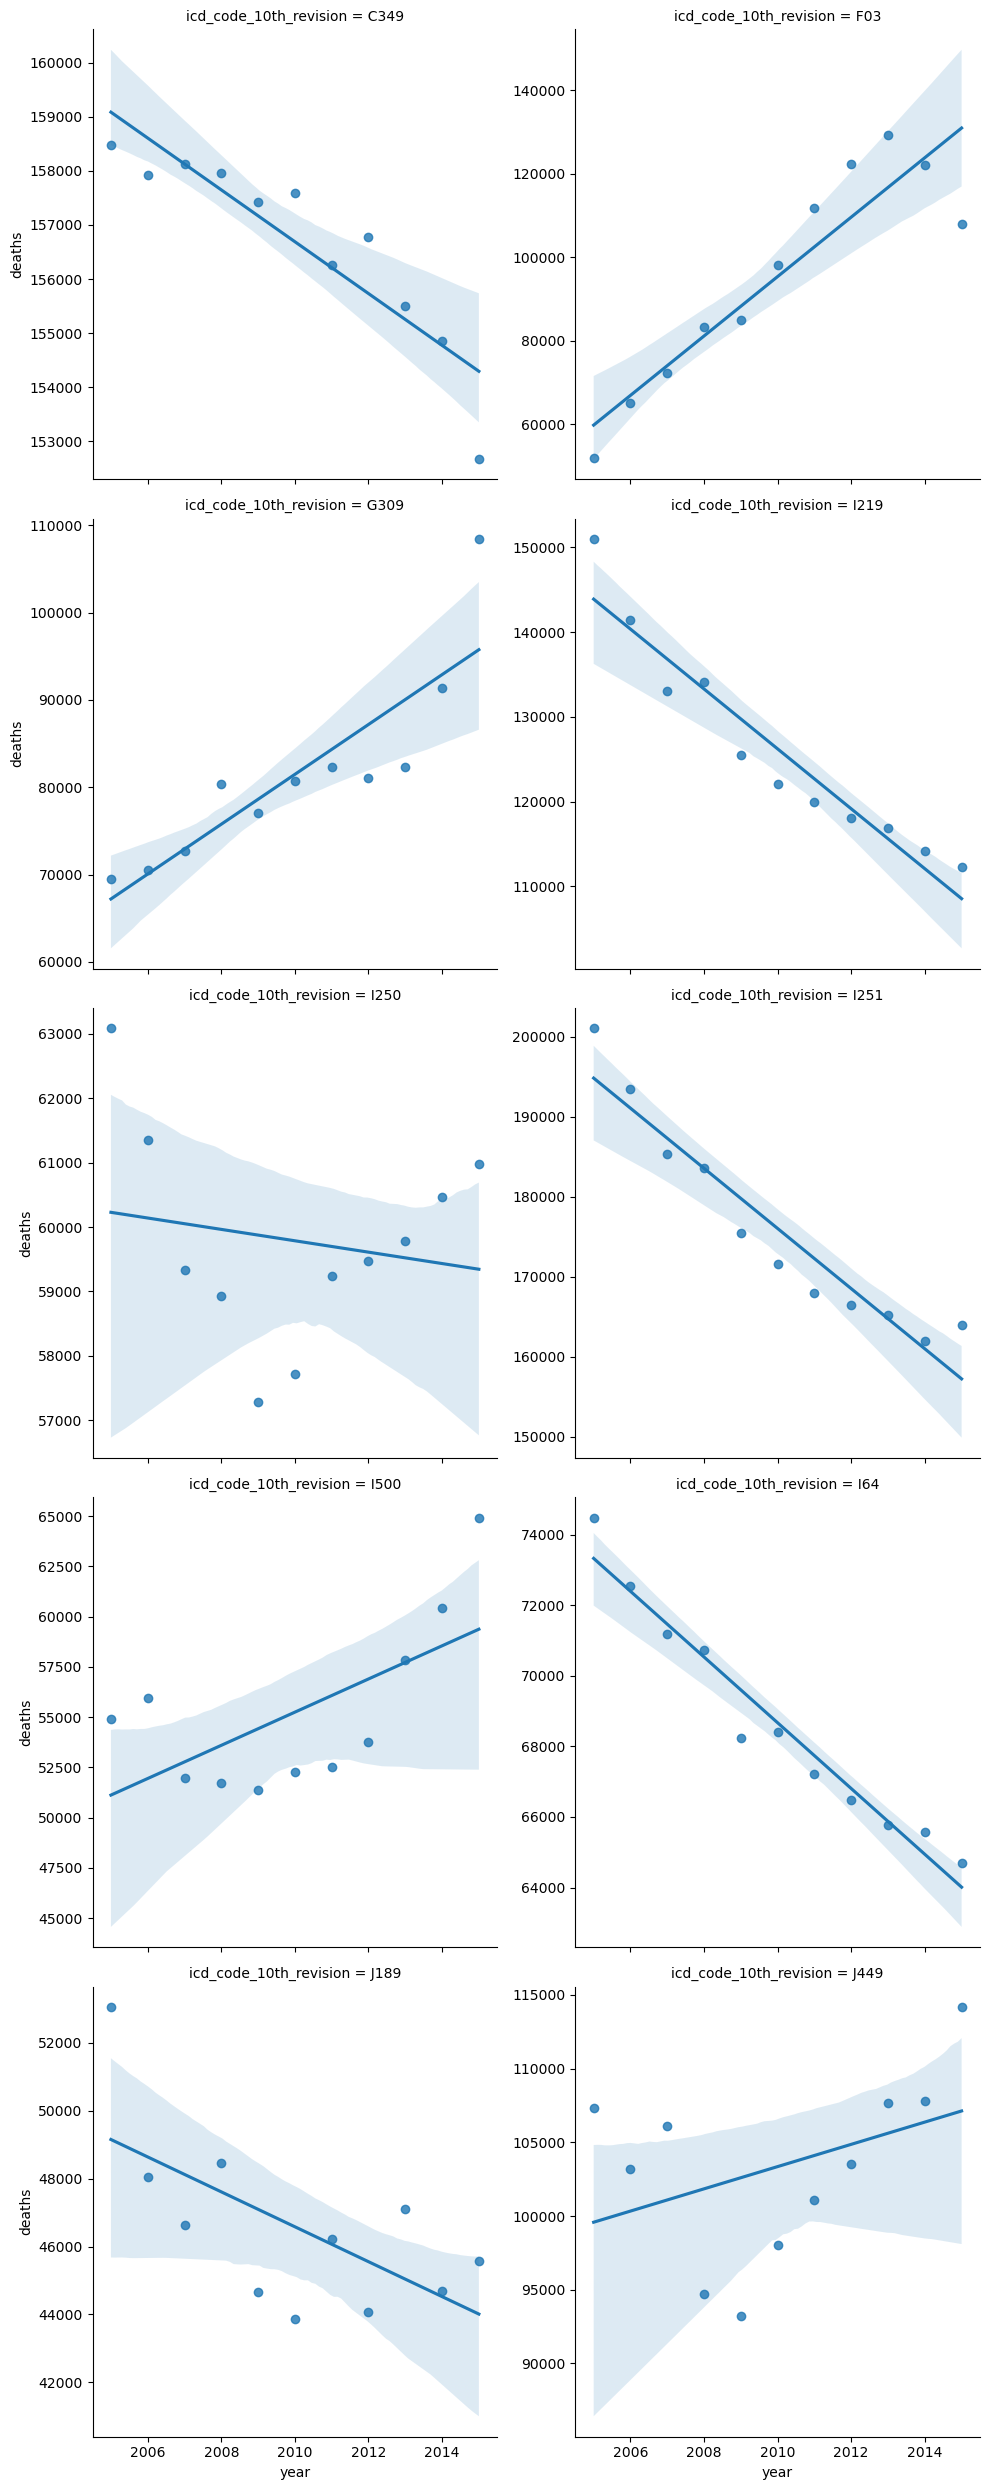

In [13]:
column = 'icd_code_10th_revision'
plot_df = icd_df.groupby(by=['current_data_year', column]).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'})
lmplot(col=column, col_wrap=2, data=plot_df, facet_kws=dict(sharey=False), seed=1, x='year', y='deaths',)
for item in plot_df[column].unique():
    title = '{}'.format(item)
    if title in annual_total_df.columns:
        annual_total_df = annual_total_df.drop(columns=[title],)
    annual_total_df = annual_total_df.merge(right=plot_df[plot_df[column] == item], on='year').drop(columns=[column]).rename(columns={'deaths' : title})
logger.info(msg='\n{}'.format(annual_total_df[icd_codes]))

Let's have a look at the regression coefficients

__main__ - 2023-06-16 17:15:18,388 - INFO - Index(['year', 'total', 'sex = F', 'sex = M', 'Asian Indian', 'Black',
       'Chinese', 'Filipino', 'Guamanian', 'Hawaiian', 'Japanese', 'Korean',
       'Native American', 'Other Asian', 'Samoan', 'Vietnamese', 'White',
       'C349', 'F03', 'G309', 'I219', 'I250', 'I251', 'I500', 'I64', 'J189',
       'J449'],
      dtype='object')


<Axes: >

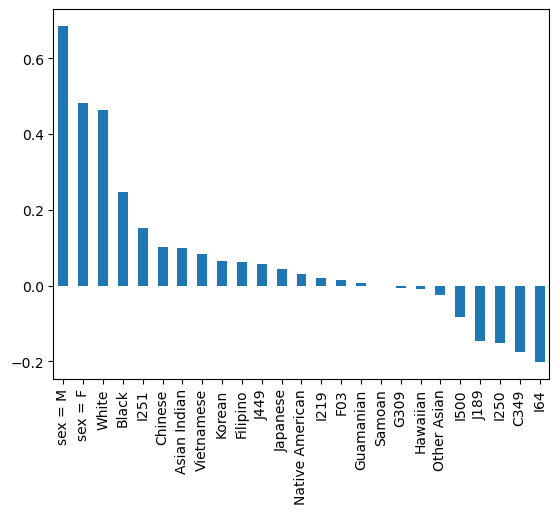

In [14]:
from pandas import DataFrame
from statsmodels.api import OLS
logger.info(msg=annual_total_df.columns)
ols_model = OLS(endog=annual_total_df['total'], exog=annual_total_df.drop(columns=['year', 'total']))
ols_results = ols_model.fit()
ols_results.params.sort_values(ascending=False, ).plot(kind='bar')

In [15]:
logger.info(msg='done')

__main__ - 2023-06-16 17:15:18,938 - INFO - done
